1: Cargar y explorar los datos

Primeras filas de la serie temporal:
            produccion
DATE                  
2020-10-01    106.2640
2020-11-01     99.5616
2020-12-01     90.4432
2021-01-01    106.0187
2021-02-01    119.2644


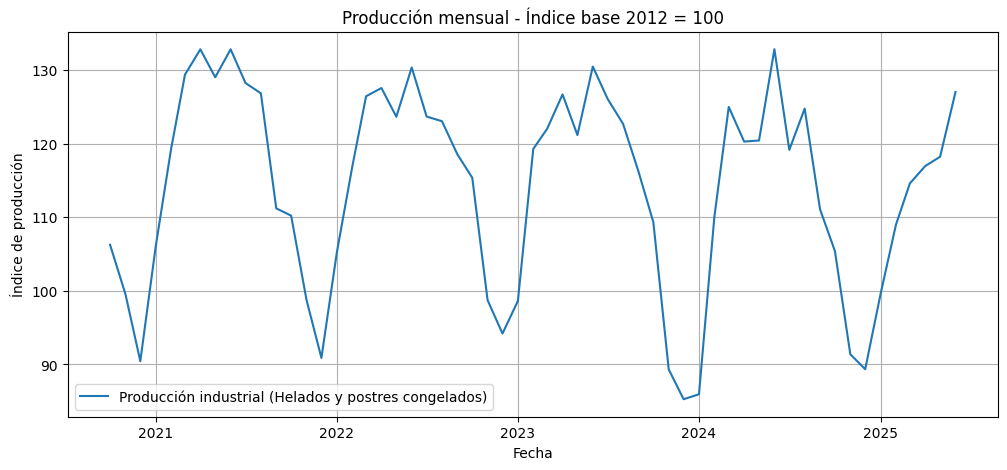

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr

serie = pdr.DataReader("IPN31152N", "fred")

serie = serie.rename(columns={"IPN31152N": "produccion"})

print("Primeras filas de la serie temporal:")
print(serie.head())

plt.figure(figsize=(12, 5))
plt.plot(serie, label="Producción industrial (Helados y postres congelados)")
plt.title("Producción mensual - Índice base 2012 = 100")
plt.xlabel("Fecha")
plt.ylabel("Índice de producción")
plt.legend()
plt.grid(True)
plt.show()


2. División de conjuntos (entrenamiento y prueba)

In [ ]:
meses_prueba = 24

entrenamiento = serie.iloc[:-meses_prueba]
prueba = serie.iloc[-meses_prueba:]

print("Tamaño del conjunto de entrenamiento:", entrenamiento.shape[0])
print("Tamaño del conjunto de prueba:", prueba.shape[0])


Tamaño del conjunto de entrenamiento: 33
Tamaño del conjunto de prueba: 24


3. Normalización y TimeSeriesGenerator

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np

scaler = MinMaxScaler()

entrenamiento_escalado = scaler.fit_transform(entrenamiento)

prueba_escalada = scaler.transform(prueba)

longitud_secuencia = 12  # secuencia de 12 meses (1 año)
batch_size = 1

generador_entrenamiento = TimeseriesGenerator(entrenamiento_escalado, entrenamiento_escalado,length=longitud_secuencia, batch_size=batch_size)

generador_prueba = TimeseriesGenerator(prueba_escalada, prueba_escalada,length=longitud_secuencia, batch_size=batch_size)

print("Secuencia de entrada del generador de entrenamiento:")
X, y = generador_entrenamiento[0]
print("Entrada (X):", X.flatten())
print("Salida (y):", y.flatten())


Ejemplo de secuencia de entrada del generador de entrenamiento:
Entrada (X): [0.37342624 0.21522615 0.         0.3676363  0.68028116 0.91862694
 0.99987254 0.91018869 1.         0.89178504 0.85887232 0.4900464 ]
Salida (y): [0.46660105]
